# KITTI
Dataset can be downloaded from https://www.cvlibs.net/datasets/kitti/

For proper directories structure, unzip KITTI dataset to data/

In [1]:
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
from ultralytics import YOLO
import random
import shutil
import os
from PIL import Image

# loading data

In [2]:
kitti_label_path = "data/KITTI/training/label_2/"
kitti_image_path = "data/KITTI/training/image_2/"

assert len(os.listdir(kitti_label_path)) == len(os.listdir(kitti_image_path))

label_paths = [kitti_label_path + file for file in sorted(os.listdir(kitti_label_path))]
image_paths = [kitti_image_path + file for file in sorted(os.listdir(kitti_image_path))]


001237
(375, 1242, 3)
144.5 238.5
1017.0 285.5
731.0 218.0
216.0 239.0
299.0 228.0
322.0 218.5
695.0 208.0
669.0 198.5
464.5 194.0
498.0 195.5


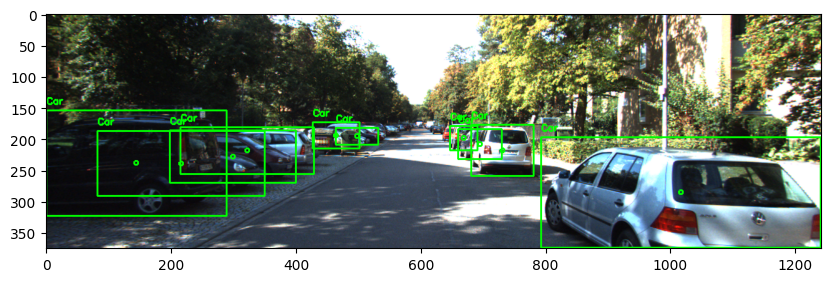

,Type,Truncated,Occluded,Alpha,BBox_x1,BBox_y1,BBox_x2,BBox_y2,Dimensions_h,Dimensions_w,Dimensions_l,Location_x,Location_y,Location_z,Rotation_y
0,Car,0.29,0,-2.54,0.00,154.62,289.06,323.02,1.89,1.59,3.87,-6.35,1.71,9.00,-3.14
1,Car,0.47,0,-2.04,793.34,197.76,1241.00,374.00,1.45,1.59,3.59,2.71,1.70,5.61,-1.61
2,Car,0.00,0,-1.70,681.32,177.31,781.88,259.73,1.66,1.74,3.65,2.61,1.78,16.50,-1.55
3,Car,0.00,2,0.52,82.44,187.36,350.17,291.61,1.52,1.49,3.50,-6.24,1.78,11.57,0.04
4,Car,0.00,2,0.45,198.80,186.95,400.32,270.00,1.49,1.60,3.24,-6.01,1.79,14.10,0.05


In [4]:
image_nr = 1237

label_path = label_paths[image_nr]
image_path = image_paths[image_nr]
print(Path(label_path).stem)

# KITTI format
columns = ['Type', 'Truncated', 'Occluded', 'Alpha', 'BBox_x1', 'BBox_y1', 'BBox_x2', 'BBox_y2', 
           'Dimensions_h', 'Dimensions_w', 'Dimensions_l', 'Location_x', 'Location_y', 'Location_z', 'Rotation_y']

data = pd.read_csv(label_path, sep=' ', header=None, names=columns)

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(image.shape)

# draw bounding boxes
for index, row in data.iterrows():
    if row['Type'] != 'DontCare':
        x1, y1, x2, y2 = int(row['BBox_x1']), int(row['BBox_y1']), int(row['BBox_x2']), int(row['BBox_y2'])
        x_center = (x1 + x2) /2
        y_center = (y1 + y2) /2
        color = (0, 255, 0) if row['Type'] == 'Car' else (255, 0, 0)
        print(x_center, y_center)
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        cv2.putText(image, row['Type'], (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        cv2.circle(image, (int(x_center), int(y_center)), 3, color=(0, 255, 0), thickness=2)


plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.show()
data.head()

## available classes

In [11]:
labels = []
for p in label_paths:
    data = pd.read_csv(p, sep=' ', header=None, names=columns)
    labels.extend(data["Type"].values.tolist())
    
set(labels)


{'Car',
 'Cyclist',
 'DontCare',
 'Misc',
 'Pedestrian',
 'Person_sitting',
 'Tram',
 'Truck',
 'Van'}

# Generate proper dir structure and labels!
Utralytics YOLO requires data to be stored in proper structure and cofig file.
https://docs.ultralytics.com/datasets/detect/#ultralytics-yolo-format

Code below can be used to move unzipped KITTI dataset into structure suited for training YOLOv8.
Proper config for training is located in configs/kitti_train_config.yml

## train/eval

In [12]:
train_ratio = 0.8
output_path = "data/KITTI/"
target_size = (640, 224)
random_image_paths = image_paths.copy()
random.shuffle(random_image_paths)
train_image_paths = random_image_paths[:round(train_ratio*len(random_image_paths))]


## moving files

In [15]:
labels_map = {
            'Car':              0,
            'Cyclist':          1,
            'Pedestrian':       2,
            'Person_sitting':   3,
            'Truck':            4,
            'Van':              5,
            'Tram':             6,
            'Misc':             7,
            'DontCare':         -1,
}


Path(output_path + "labels/train/").mkdir(parents=True, exist_ok=True)
Path(output_path + "labels/val/").mkdir(parents=True, exist_ok=True)
Path(output_path + "images/train/").mkdir(parents=True, exist_ok=True)
Path(output_path + "images/val/").mkdir(parents=True, exist_ok=True)

for image_path, label_path in zip(image_paths, label_paths):
    data = pd.read_csv(label_path, sep=' ', header=None, names=columns)
    labels = data["Type"].values
    new_labels = [labels_map[label] for label in labels]

    x1 = data["BBox_x1"].values
    y1 = data["BBox_y1"].values
    x2 = data["BBox_x2"].values
    y2 = data["BBox_y2"].values

    image = cv2.imread(image_path)
    h, w, c = image.shape

    x_center = (x1 +x2) / 2
    x_center /= w
    y_center = (y1 + y2) / 2
    y_center /= h


    width = (abs(x1-x2))/w
    height   = (abs(y1-y2))/h

    assert len(x_center) == len(y_center) == len(width) == len(height) == len(new_labels)

    
    new_label_path = output_path + "labels/"
    new_image_path = output_path + "images/"

    if image_path in train_image_paths:
        new_label_path += "train/"
        new_image_path += "train/"
    else:
        new_label_path += "val/"
        new_image_path += "val/"
    
    new_label_path += Path(label_path).name
    new_image_path += Path(image_path).name
    
    #shutil.copy(image_path, new_image_path)
    with Image.open(image_path) as img:
        img = img.resize(target_size)
        img.save(new_image_path)


    if len(new_labels) > 0:
        lines = []
        for label, x, y, w, h in zip(new_labels, x_center, y_center, width, height):
            if label != -1:
                lines.append(f"{label} {x} {y} {w} {h}\n")
        if len(lines) > 0:
            with open(new_label_path, 'w') as file:
                file.writelines(lines)


## sanity check

data/KITTI/images/train/002433.png
(194, 640, 3)


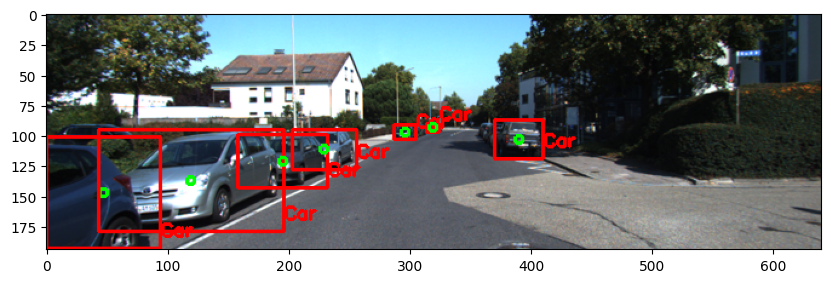

,label,x,y,w,h
0,0,0.073752,0.759760,0.147504,0.475147
1,0,0.187468,0.708707,0.240346,0.434213
2,0,0.609980,0.532573,0.063663,0.166907
3,0,0.306014,0.624547,0.115958,0.227333
4,0,0.359167,0.575373,0.082343,0.170587


In [51]:
image_nr=1944

new_label_paths = ["data/KITTI/labels/train/" + file for file in sorted(os.listdir("data/KITTI/labels/train/"))]
new_image_paths = ["data/KITTI/images/train/" + file for file in sorted(os.listdir("data/KITTI/images/train/"))]

image_path = new_image_paths[image_nr]#"data/KITTI/labels/train/000170.txt"#new_image_paths[image_nr]
label_path =new_label_paths[image_nr]#"data/KITTI/images/train/000001.png"#new_label_paths[image_nr]
print(image_path)

columns = ['label', 'x', 'y', 'w', 'h']

data = pd.read_csv(label_path, sep=' ', header=None, names=columns)

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(image.shape)

# draw bounding boxes
for index, row in data.iterrows():
    #x1, y1, x2, y2 = int(row['BBox_x1']), int(row['BBox_y1']), int(row['BBox_x2']), int(row['BBox_y2'])
    x1 = int((row['x'] + row['w']/2)*image.shape[1])
    y1 = int((row['y'] + row['h']/2)*image.shape[0])
    x2 = int((row['x'] - row['w']/2)*image.shape[1])
    y2 = int((row['y'] - row['h']/2)*image.shape[0])
    x_center = row['x']*image.shape[1]
    y_center = row['y']*image.shape[0]
    color = (0, 255, 0) if row['label'] == 'car' else (255, 0, 0)
    cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
    cv2.putText(image, next(key for key, value in labels_map.items() if value == row['label']), (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    cv2.circle(image, (int(x_center), int(y_center)), 3, color=(0, 255, 0), thickness=2)


plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.show()
data.head()